**Engy-4390** Nuclear Systems and Design Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Heated Plate
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\flux}{\boldsymbol{q}}
  \newcommand{\fluxc}{\boldsymbol{q}_\text{c}}
  \newcommand{\fluxf}{\boldsymbol{q}_\text{f}}
  \newcommand{\velocity}{\boldsymbol{v}}
  \newcommand{\normal}{\boldsymbol{n}}
  \newcommand{\xpoint}{\boldsymbol{x}}
  \newcommand{\Tc}{T_\text{c}}
  \newcommand{\wc}{w_\text{c}}
  \newcommand{\Tf}{T_\text{f}}
  \newcommand{\wf}{w_\text{f}}
  \newcommand{\wI}{w_\text{I}}
  \newcommand{\Ri}{R_\text{i}}
  \newcommand{\Ro}{R_\text{o}}
  \newcommand{\Omegac}{\Omega_\text{c}}
  \newcommand{\Omegaf}{\Omega_\text{f}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\div}{div}
  \DeclareMathOperator{\gradx}{grad_\xpoint}
  \DeclareMathOperator{\divx}{div_\xpoint}
  \DeclareMathOperator{\grad}{grad}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

**Student(s):**  `Noah Johnson` <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** `Valmor de Almeida`

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**07Oct2024**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
  + [Weak Form of Problem Statement](#weakform)
* [Test 1](#1dsolofueldirichlet)
* [Test 2](#3DomainsNeumannRobin)
* [Test 3](#3DomainsNeumannNeumann)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

The UMass Lowell Research Reactor (UMLRR) is a pool type research reactor initially constructed in 1974. It has used LEU plate fuel since the early 2000s and operates at a maximum thermal power of 1 MW. Fuel is contained in 21 assemblies within the core, cooled either passively or by forced convection. A scale model of a single assembly has been constructed using aluminum plates in the place of fuel, some of which are equipped with electric heating elements to model reactor heat generation. Some of these plates are also outfitted with embedded thermocouples so that a temperature profile can be read from the assembly. The assembly is designed to be submerged within a lab-scale tank of water so reactor heat transfer can be studied in a controlled environment. The problem studied here is a 1D cross section of the assembly focused on a heated plate, the boundary coolant channel, and the adjacent plate. 

## [Problem Statement](#toc)<a id="problem"></a>

Solve the heat conduction problem 1/2 plate. Find $u:[a,b]\text{ } \mathbb{R} \rightarrow \mathbb{R}$ such that:

\begin{align*}
 -\bigl(-D(x)\, u'(x)\bigr)'(x) + f(x)\, &= 0  & \forall \qquad  x \in [a,b], \\
 q_n(a) &= 0 &  \text{Neumann B.C.}, \\
 q_n(b) &= h(u-u_\text{ref}) & \text{Robin B.C.}
\end{align*}
   
Given data: spatially varying thermal conductivity coefficient, $D(x)$, $u_\text{ref}$ = 25 °C, h = 1.02 $\frac{\text{W}}{\text{in}^2\,K}$ and spatially varying source bias $f(x)$. 

In [2]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from pyheat_plate import *

In [3]:
from scipy import constants as unit
unit.kelvin = 1.0
unit.second = 1.0
unit.joule = 1.0
unit.meter = 1.0
unit.watt = unit.joule/unit.second
unit.kg = unit.kilo*unit.gram
unit.cm = unit.meter*unit.centi

In [4]:
def domain_viz(option='all'):
    fig = plt.figure(figsize=(15,5))
    num_pts = 100
    assert option in ['all', 'test_1', 'test_2', 'test_3']
    a = 0.0*unit.inch/unit.cm  # symmetry, [in]
    b = 0.05*unit.inch/unit.cm  # interface position [in]
    c = 0.20*unit.inch/unit.cm  # aluminum interface position [in]

    plt.plot([b,b], [0,1], "k--")
    plt.plot([c,c], [0,1], "k--")
    plt.grid()
    
    if option == 'all':
        d = c + 0.1*unit.inch/unit.cm # right most end [in]

        x = np.linspace(0, d, num_pts)
        y = np.linspace(1, 1, num_pts)
        
        x_a = np.linspace(a, b, num_pts)
        x_b = np.linspace(b, c, num_pts)
        x_c = np.linspace(c, d, num_pts)
        y0 = np.linspace(0, 0, num_pts)

        plt.plot(x, y, "k-")

        section = np.arange(a, b, 1/20.)
        plt.fill_between(x_a, y, y0,color="red")
        plt.fill_between(x_b, y, y0,color="cyan")
        plt.fill_between(x_c, y, y0,color="gray")

        # Domain Labels
        plt.text((b-a)/2 + a, 0.8, "Heater",color="black",fontsize=16,weight="bold",horizontalalignment="center")
        plt.text((c-b)/2 + b, 0.8, "Water",color="black",fontsize=16,weight="bold",horizontalalignment="center")
        plt.text((d-c)/2 + c, 0.8, "Aluminum",color="black",fontsize=16,weight="bold",horizontalalignment="center")

        # Heater B.C. and gov eqn
        plt.text(a, 0.4, "$q_{0} = 0$",color="black",fontsize=16)
        plt.text((b-a)/2 + a, 0.65,r"$k\Delta T + S = 0$",color="black",fontsize=16,horizontalalignment="center")

        # Water B.C. and gov eqn
        plt.text((c-b)/2 + b, 0.65, r"$k\Delta T= 0$",color="black",fontsize=16, horizontalalignment="center")
        plt.text(b, 0.4, r"$q_\text{fluid} = q_\text{surface}$",color="black",fontsize=16)
        plt.text(b, 0.2, r"$T_\text{fluid} = T_\text{surface}$",color="black",fontsize=16)

        plt.text((d-c)/2 + c, 0.65, r"$k\Delta T= 0$",color="black",fontsize=16, horizontalalignment="center")
        plt.text(c, 0.4, r"$q_\text{Al} = h(T-T_{\infty})$",color="black",fontsize=16)

    elif option == 'test_1':

        x = np.linspace(0, c, num_pts)
        y = np.linspace(1, 1, num_pts)

        x_a = np.linspace(a, b, num_pts)
        x_b = np.linspace(b, c, num_pts)

        y0 = np.linspace(0, 0, num_pts)

        plt.plot(x, y, "k-")
        
        section = np.arange(a, b, 1/20.)
        plt.fill_between(x_a,y,y0,color="red")
        plt.fill_between(x_b,y,y0,color="cyan")

        # Domain Labels
        plt.text((b-a)/2 + a ,0.8,"Heater",color="black",fontsize=16,weight="bold",horizontalalignment="center")
        plt.text((c-b)/2 + b,0.8,"Water",color="black",fontsize=16,weight="bold",horizontalalignment="center")

        # Heater B.C. and gov eqn
        plt.text(a,0.4,"$q_{0} = 0$",color="black",fontsize=16)
        plt.text((b-a)/2 + a,0.65,r"$k\Delta T + S = 0$",color="black",fontsize=16,horizontalalignment="center")

        # Water B.C. and gov eqn
        plt.text((c-b)/2 + b,0.65,r"$k\Delta T= 0$",color="black",fontsize=16, horizontalalignment="center")
        plt.text(b,0.4,r"$q_\text{fluid} = q_\text{surface}$",color="black",fontsize=16)
        plt.text(b,0.2,r"$T_\text{fluid} = T_\text{surface}$",color="black",fontsize=16)

        plt.text(c,0.4,r"$q_\text{Al} = h(T-T_{\infty})$",color="black",fontsize=16)
    
    elif option == 'test_2':

        d = 0.25*unit.inch/unit.cm # right boundary

        x = np.linspace(0, d, num_pts)
        y = np.linspace(1,1, num_pts)

        x_a = np.linspace(a, b, num_pts)
        x_b = np.linspace(b, c, num_pts)
        x_c = np.linspace(c, d, num_pts)
        y0 = np.linspace(0, 0, num_pts)

        plt.plot(x, y, "k-")

        section = np.arange(a,b, 1/20.)
        plt.fill_between(x_a,y,y0,color="red")
        plt.fill_between(x_b,y,y0,color="cyan")
        plt.fill_between(x_c,y,y0,color="gray")

        # Domain Labels
        plt.text((b-a)/2 + a ,0.8,"Heater",color="black",fontsize=16,weight="bold",horizontalalignment="center")
        plt.text((c-b)/2 + b,0.8,"Water",color="black",fontsize=16,weight="bold",horizontalalignment="center")
        plt.text((d-c)/2 + c,0.8,"Aluminum",color="black",fontsize=16,weight="bold",horizontalalignment="center")

        # Heater B.C. and gov eqn
        plt.text(a,0.4,"$q_{0} = 0$",color="black",fontsize=16)
        plt.text((b-a)/2 + a,0.65,r"$k\Delta T + S = 0$",color="black",fontsize=16,horizontalalignment="center")

        # Water B.C. and gov eqn
        plt.text((c-b)/2 + b,0.65,r"$k\Delta T= 0$",color="black",fontsize=16, horizontalalignment="center")
        plt.text(b,0.4,r"$q_\text{fluid} = q_\text{surface}$",color="black",fontsize=16)
        plt.text(b,0.2,r"$T_\text{fluid} = T_\text{surface}$",color="black",fontsize=16)
        plt.text(c,0.4,r"$q_\text{fluid} = q_\text{surface}$",color="black",fontsize=16)
        plt.text(c,0.2,r"$T_\text{fluid} = T_\text{surface}$",color="black",fontsize=16)

        # Aluminum
        plt.text((d-c)/2 + c, 0.65, r"$k\Delta T= 0$",color="black",fontsize=16, horizontalalignment="center")
        plt.text(d,0.4,r"$q_\text{Al} = h(T-T_{\infty})$",color="black",fontsize=16)

    elif option == 'test_3':

        d = 0.25*unit.inch/unit.cm # right boundary

        x = np.linspace(0, d, num_pts)
        y = np.linspace(1, 1, num_pts)

        x_a = np.linspace(a, b, num_pts)
        x_b = np.linspace(b, c, num_pts)
        x_c = np.linspace(c, d, num_pts)
        y0 = np.linspace(0,0, num_pts)

        plt.plot(x, y, "k-")

        section = np.arange(a,b, 1/20.)
        plt.fill_between(x_a,y,y0,color="red")
        plt.fill_between(x_b,y,y0,color="cyan")
        plt.fill_between(x_c,y,y0,color="gray")

        # Domain Labels
        plt.text((b-a)/2 + a ,0.8,"Heater",color="black",fontsize=16,weight="bold",horizontalalignment="center")
        plt.text((c-b)/2 + b,0.8,"Water",color="black",fontsize=16,weight="bold",horizontalalignment="center")
        plt.text((d-c)/2 + c,0.8,"Aluminum",color="black",fontsize=16,weight="bold",horizontalalignment="center")

        # Heater B.C. and gov eqn
        plt.text(a,0.4,"$q_{0} = 0$",color="black",fontsize=16)
        plt.text((b-a)/2 + a,0.65,r"$k\Delta T + S_h = 0$",color="black",fontsize=16,horizontalalignment="center")

        # Water B.C. and gov eqn
        plt.text((c-b)/2 + b,0.65,r"$k\Delta T= 0$",color="black",fontsize=16, horizontalalignment="center")
        plt.text(b,0.4,r"$q_\text{fluid} = q_\text{surface}$",color="black",fontsize=16)
        plt.text(b,0.2,r"$T_\text{fluid} = T_\text{surface}$",color="black",fontsize=16)
        plt.text(c,0.4,r"$q_\text{fluid} = q_\text{surface}$",color="black",fontsize=16)
        plt.text(c,0.2,r"$T_\text{fluid} = T_\text{surface}$",color="black",fontsize=16)

        # Aluminum
        plt.text((d-c)/2 + c, 0.65, r"$k\Delta T + S_c = 0$",color="black",fontsize=16, horizontalalignment="center")
        plt.text(d,0.4,r"$q_\text{Al} = h(T-T_{\infty})$",color="black",fontsize=16)
        
    plt.xlabel(r"x [cm]",fontsize=16)    
    plt.show()

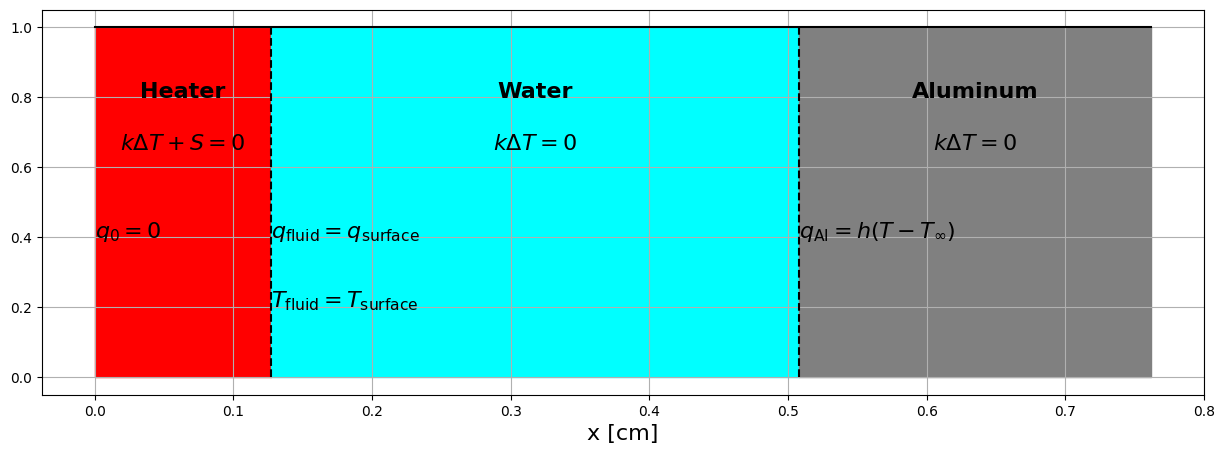

In [4]:
domain_viz('all')

## [Approach](#toc)<a id="app"></a>

## Neumann (left) / Robin (right) B.C. 

\begin{align*}
    A_{i,j} = (k\, \phi_i^\prime, \phi_j^\prime) - (S\,\phi_i, \phi_j) + h\,\phi_j(b)\phi_i(b) \\
    b_{i} = (f,\phi_i)  - q_{n}(a)\,\phi_i(a) + h\,u_\text{ref}\phi_i(b)
\end{align*}


A Galerkin weak formulation follows below and the implementation of the integrands are described next.

## [Test 1](#toc)<a id="1dsolofueldirichlet"></a>

### Plate/Coolant w/ Neumann/Robin BC

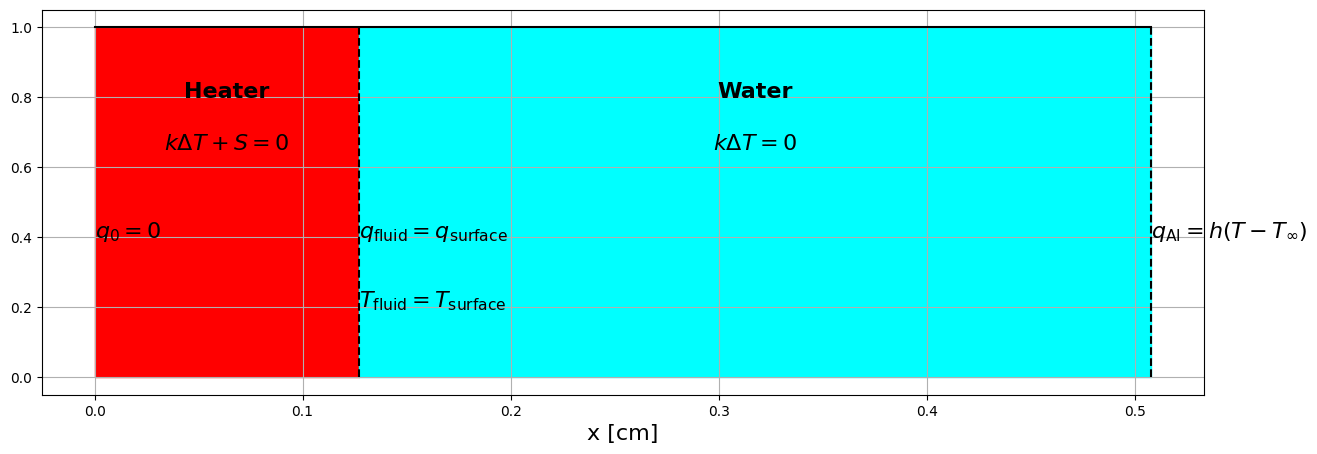

In [5]:
domain_viz('test_1')

In [9]:
k_plate = 6.096*unit.watt/unit.inch/unit.kelvin
k_coolant = 0.01524*unit.watt/unit.inch/unit.kelvin
rho_coolant = 0.0164*unit.kg/unit.inch**3
cp_coolant = 4168*unit.joule/unit.kg/unit.kelvin

s_source = 56.818*unit.watt/unit.inch**3

#x_i_r transfer
heat_transfer_coeff = 1000 *unit.watt/unit.meter**2/unit.kelvin
temp_ref = unit.convert_temperature(25, 'C', 'K')

In [7]:
'''Parameters'''
#Degree of lagrange polynomials to be used
degree = 2
n_felem_plate = 10
n_felem_coolant = 10

In [8]:
'''Setting up the FEM solution'''
x_a = 0.0*unit.inch
x_b = 0.20*unit.inch

#Location where domain is split into subdomains
interface_loc = 0.05*unit.inch
locList = [interface_loc]

#Number of elements in each subdomain
numPartsList = [n_felem_plate, n_felem_coolant]

#Boundary condition types
bc_x_min = "neumann"
bc_x_max = "robin"

#Create whole domain partition
domain_partition = get_domain_partition(degree, locList,numPartsList, x_a, x_b, bc_x_min, bc_x_max)

kList = [k_plate, k_coolant]

#Heat Transfer Coefficient
h_coeff = heat_transfer_coeff     

#Boundary Conditions (neumann on left, robin on right)
x_min_flux = 0
x_max_u_ref = temp_ref  #deg C

#Create shape points that define the k, w, s, and f functions for the fem object
k_shape_pts = [(x_a, kList[0]), (interface_loc*0.9999999, kList[0]), (interface_loc, kList[1]), (x_b, kList[1])]
w_shape_pts =[(x_a, 0), (x_b, 0)]
s_shape_pts =[(x_a, 0), (x_b, 0)]
f_shape_pts = [(x_a, s_source), (interface_loc*0.9999999, s_source), (interface_loc,0), (x_b,0)]

#Create finite element object
femlb_1 = femLagrange(x_a, x_b, degree, 1, f_shape_pts, k_shape_pts, s_shape_pts, w_shape_pts, 
                      domain_partition, 0, 0, 0, 0, bc_x_min, bc_x_max, h_coeff, x_min_flux, x_max_u_ref)

# Assembly of FEM problem
a_mtrx = assemble_a_mtrx_neumann_robin(femlb_1)
b_vec = assemble_b_vec_neumann_robin(femlb_1)

In [9]:
'''Checking linear system matrix of coefficients'''
print("a_mtrx rank:", np.linalg.matrix_rank(a_mtrx))
print("a_mtrx shape:",a_mtrx.shape)
if np.linalg.matrix_rank(a_mtrx) == min(a_mtrx.shape):
    print("A mtrx is full rank")
else:
    assert False, 'The matrix cannot be rank deficient.'

a_mtrx rank: 41
a_mtrx shape: (41, 41)
A mtrx is full rank


In [10]:
'''Solve FEM problem'''
c_star_1 = np.linalg.solve(a_mtrx,b_vec)

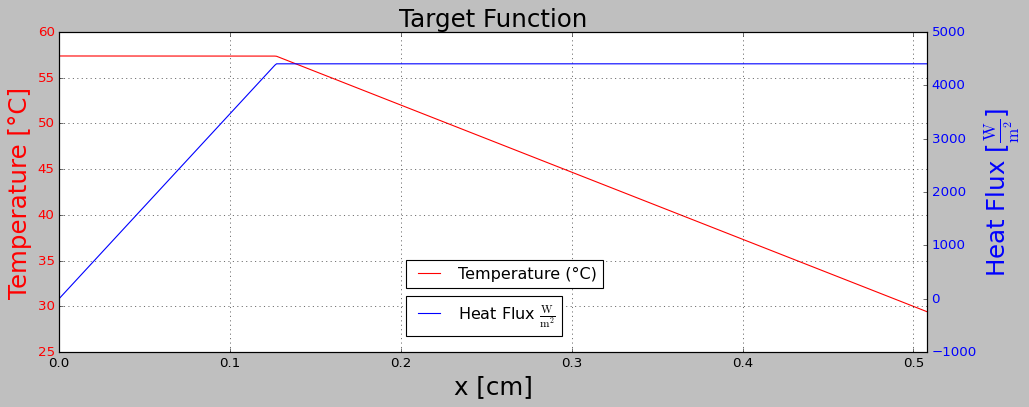

In [11]:
'''Display solution'''
plt.style.use('classic')
n_pts = 500
x_pts = np.linspace(femlb_1.x_a, femlb_1.x_b, n_pts)
N = len(femlb_1.phi_list)

(fig, ax1) = plt.subplots(1, figsize=(14, 5))
ax2 = ax1.twinx()
ax1.plot(x_pts/unit.centi, unit.convert_temperature(u_star(x_pts, femlb_1, c_star_1),'K','C'), "r-", label="Temperature (°C)")
ax2.plot(x_pts/unit.centi, diff_flux_x_star(x_pts, femlb_1, c_star_1), "b-", label=r"Heat Flux $\frac{\text{W}}{\text{m}^2}$")
ax1.grid()
plt.title(r"Target Function",fontsize=22)
ax1.set_ylabel(r"Temperature [°C]",fontsize=22, color="red")
ax2.set_ylabel(r"Heat Flux [$\frac{\text{W}}{{\text{m}}^2}$]",fontsize=22, color="blue")
ax1.set_xlabel(r"x [cm]",fontsize=22)
ax1.tick_params(axis="y",labelcolor="red")
ax2.tick_params(axis="y",labelcolor="blue")
ax1.legend(loc=(0.4,0.2))
ax2.legend(loc=(0.4,0.05))
ax1.set_xlim(x_a/unit.centi, x_b/unit.centi)
plt.show()

In [12]:
'''Derived boundary data from solution'''
left_bound_temp = unit.convert_temperature(u_star(x_a, femlb_1, c_star_1)[0],'K','C')
right_bound_temp = unit.convert_temperature(u_star(x_b, femlb_1, c_star_1)[0],'K','C')

left_bound_flux = diff_flux_x_star(x_a, femlb_1, c_star_1)[0]
right_bound_flux = diff_flux_x_star(x_b, femlb_1, c_star_1)[0]

print("Left bound temperature:",format(left_bound_temp,".2f"),"°C")
print("Right bound temperature:",format(right_bound_temp,".2f"),"°C")
print("*"*60)
print("Left bound flux:", format(left_bound_flux, ".2f"), r"W/m2")
print("Right bound flux:", format(right_bound_flux, ".2f"), r"W/m2")
print("u_ref:", unit.convert_temperature(x_max_u_ref,'K','C'), "°C")
print("h:", h_coeff, "W/m^2 K")

Left bound temperature: 57.38 °C
Right bound temperature: 29.40 °C
************************************************************
Left bound flux: -0.00 W/m2
Right bound flux: 4403.40 W/m2
u_ref: 25.0 °C
h: 1000.0 W/m^2 K


In [13]:
'''Raw data results'''
import pandas as pd
from IPython.display import HTML

x_table = np.linspace(femlb_1.x_a, femlb_1.x_b, 20)

u_values = u_star(x_table, femlb_1, c_star_1) 
q_values = diff_flux_x_star(x_table, femlb_1, c_star_1)

df = pd.DataFrame({"x [cm]":x_table*100, "T [K]":u_values, "q_x [W/m^2]":q_values})
pd.options.display.float_format = '{:,.3f}'.format
HTML(df.to_html(index=False))

x [cm],T [K],q_x [W/m^2]
0.000,330.527,-0.000
0.027,330.526,927.032
0.053,330.525,"1,854.065"
0.080,330.522,"2,781.097"
0.107,330.518,"3,708.130"
0.134,330.024,"4,403.404"
0.160,328.062,"4,403.404"
0.187,326.100,"4,403.404"
0.214,324.138,"4,403.404"
0.241,322.176,"4,403.404"


## [Test 2](#toc)<a id="3DomainsNeumannRobin"></a>
### Plate/Coolant/Aluminum w/ Neumann/Robin BC

In [ ]:
domain_viz('test_2')

In [ ]:
'''Parameters'''
n_felem_plate = 10
n_felem_coolant = 10
n_felem_plate_2 = 10

In [ ]:
degree = 2
liftDegree = 1

#Interface locations
x_int_a = 0.05*unit.inch
x_int_b = 0.20*unit.inch

x_a = 0.0*unit.inch
x_b = 0.25*unit.inch

locList = [x_int_a, x_int_b]
numPartsList = [n_felem_plate, n_felem_coolant, n_felem_plate_2]

bc_x_min = "neumann"
bc_x_max = "robin"

domain_partition = get_domain_partition(degree, locList,numPartsList, x_a, x_b, bc_x_min, bc_x_max)

kList = [k_plate, k_coolant, k_plate]

#Heat Transfer Coefficient
h_coeff = heat_transfer_coeff     

#Boundary Conditions (neumann on left, robin on right)
x_min_flux = 0
x_max_u_ref = temp_ref  #deg C


k_shape_pts = [(x_a,kList[0]),(x_int_a*0.99999,kList[0]),(x_int_a,kList[1]),(x_int_b*0.99999,kList[1]),(x_int_b,kList[2]),(x_b,kList[2])]
w_shape_pts =[(x_a, 0), (x_b, 0)]
s_shape_pts =[(x_a, 0), (x_b, 0)]
f_shape_pts = [(x_a, s_source), (x_int_a*0.99999, s_source), (x_int_a,0), (x_b,0)]

femlb_2 = femLagrange(x_a, x_b, degree, 1, f_shape_pts, k_shape_pts, s_shape_pts, w_shape_pts, 
                      domain_partition, 0, 0, 0, 0, bc_x_min, bc_x_max, h_coeff, x_min_flux, x_max_u_ref)

a_mtrx = assemble_a_mtrx_neumann_robin(femlb_2)

b_vec = assemble_b_vec_neumann_robin(femlb_2)

In [ ]:
print("a_mtrx rank:",np.linalg.matrix_rank(a_mtrx))
print("a_mtrx shape:",a_mtrx.shape)
if np.linalg.matrix_rank(a_mtrx) == min(a_mtrx.shape):
    print("A mtrx is full rank")
else:
    assert False, 'Matrix must be full rank'

In [ ]:
c_star_2 = np.linalg.solve(a_mtrx,b_vec)

n_pts = 500
x_pts = np.linspace(femlb_2.x_a, femlb_2.x_b, n_pts)
N = len(femlb_1.phi_list)

(fig, ax1) = plt.subplots(1, figsize=(14, 5))
ax2 = ax1.twinx()
plt.style.use('classic')
ax1.plot(x_pts/unit.centi, unit.convert_temperature(u_star(x_pts,femlb_2,c_star_2),'K','C'),"r-",label="Temperature (°C)")
ax2.plot(x_pts/unit.centi, diff_flux_x_star(x_pts,femlb_2,c_star_2),"b-",label=r"Heat Flux $\frac{W}{m^2}$")
ax1.grid()
plt.title(f"Target Function",fontsize=22)
ax1.set_ylabel(r"Temperature (°C)",fontsize=22, color="red")
ax2.set_ylabel(r"$\frac{W}{{m}^2}$",fontsize=22, color="blue")
ax1.set_xlabel(r"x [cm]",fontsize=16)
ax1.tick_params(axis="y",labelcolor="red")
ax2.tick_params(axis="y",labelcolor="blue")
ax1.legend(loc=(0.4,0.2))
ax2.legend(loc=(0.4,0.05))
ax1.set_xlim(x_a/unit.centi, x_b/unit.centi)
plt.show()

In [ ]:
left_bound_temp = unit.convert_temperature(u_star(x_a,femlb_2,c_star_2)[0],'K','C')
right_bound_temp = unit.convert_temperature(u_star(x_b,femlb_2,c_star_2)[0],'K','C')

left_bound_flux =diff_flux_x_star(x_a, femlb_2, c_star_2)[0]
right_bound_flux = diff_flux_x_star(x_b, femlb_2, c_star_2)[0]
print("Left bound temperature:",format(left_bound_temp, ".2f"),"°C")
print("Right bound temperature:",format(right_bound_temp, ".2f"),"°C")
print("*"*60)
print("Left bound flux:",format(left_bound_flux,".2f"),r"W/m2 K")
print("Right bound flux:",format(right_bound_flux,".2f"),r"W/m2 K")
print("\nu_ref:",unit.convert_temperature(x_max_u_ref,'K','C'),"°C")
print("h:", h_coeff, "W/m^2 K")

In [ ]:
import pandas as pd
from IPython.display import HTML

x_table = np.linspace(femlb_2.x_a,femlb_2.x_b,20)

u_values = u_star(x_table,femlb_2,c_star_2) 
q_values = diff_flux_x_star(x_table,femlb_2,c_star_2)

df = pd.DataFrame({"x [cm]":x_table*100,"T [K]":u_values,"q_x [W/m^2]":q_values})
pd.options.display.float_format = '{:,.3f}'.format
HTML(df.to_html(index=False))

## [Test 3](#toc)<a id="3DomainsNeumannNeumann"></a>
### Plate/Coolant/Aluminum w/ Coolant Heat Sink and Neumann/Robin BC

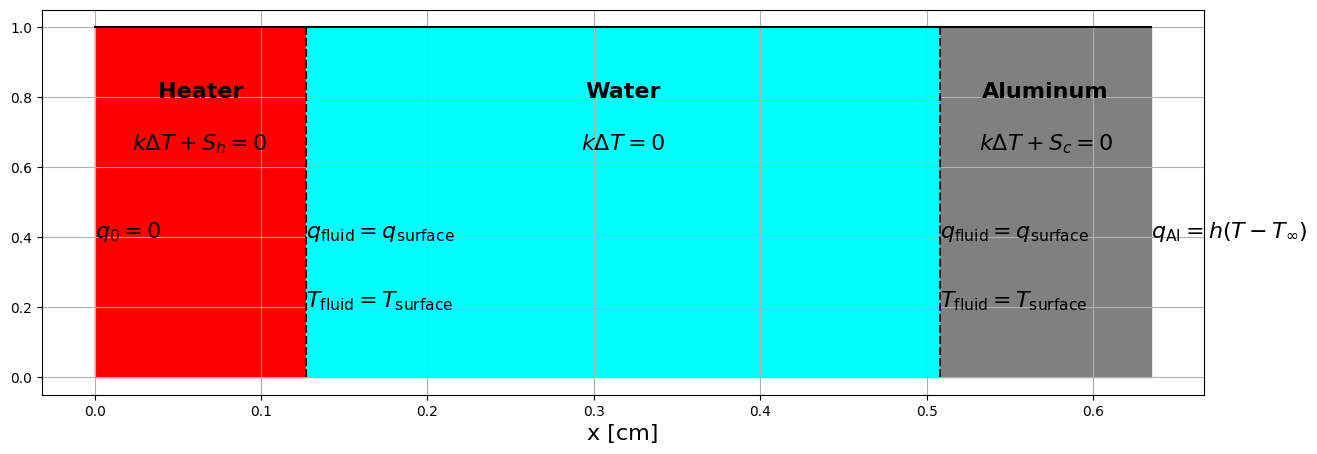

In [10]:
domain_viz('test_3')

In [11]:
#Interface locations
x_int_a = 0.05*unit.inch
x_int_b = 0.20*unit.inch

x_a = 0.0*unit.inch
x_b = 0.25*unit.inch

locList = [x_int_a,x_int_b]
#numPartsList = [n_felem_plate,n_felem_coolant,n_felem_plate_2]
numPartsList=[5,5,5]
bc_x_min = "neumann"
bc_x_max = "robin"

domain_partition = get_domain_partition(degree, locList,numPartsList, x_a, x_b,bc_x_min,bc_x_max)

# Heat Transfer Coefficient
h_coeff = 1e-5 # W/m2/K; small leak

# Heat sink in coolant
s_source_coolant = -s_source * (x_int_a - x_a) / (x_int_b - x_int_a) # heat source scaled by ratio of heater thickness to water channel

# Boundary Conditions (neumann on left, robin on right)
x_min_flux = 0
#x_max_u_ref = temp_ref  #K
x_max_u_ref = 290.2  #K

k_shape_pts = [(x_a, k_plate), (x_int_a*0.99999, k_plate), 
               (x_int_a, k_coolant), (x_int_b*0.99999, k_coolant), 
               (x_int_b, k_plate), (x_b, k_plate)]
w_shape_pts =[(x_a, 0), (x_b, 0)]
s_shape_pts =[(x_a, 0), (x_b, 0)]
f_shape_pts = [(x_a, s_source), (x_int_a*0.99999, s_source), 
               (x_int_a, s_source_coolant), (x_int_b*0.99999, s_source_coolant), 
               (x_int_b, 0), (x_b, 0)]

femlb_3 = femLagrange(x_a, x_b, degree, 1, f_shape_pts, k_shape_pts, s_shape_pts, w_shape_pts,
                      domain_partition, 0, 0,0, 0, bc_x_min, bc_x_max, h_coeff, x_min_flux, x_max_u_ref)

a_mtrx = assemble_a_mtrx_neumann_robin(femlb_3)

b_vec = assemble_b_vec_neumann_robin(femlb_3)

integral_of_source_bias = scipy.integrate.quad(femlb_3.source_bias, x_a, x_b)
print("Integral of source bias is",integral_of_source_bias[0])

Integral of source bias is 7.305336674807663e-15


In [12]:
print("a_mtrx rank:",np.linalg.matrix_rank(a_mtrx))
print("a_mtrx shape:",a_mtrx.shape)
if np.linalg.matrix_rank(a_mtrx) == min(a_mtrx.shape):
    print("A mtrx is full rank")
else:
    print("A mtrx is deficient")
    id_mtrx = np.identity(a_mtrx.shape[0])
    eps = 1e-5

    a_mtrx_fixed = (a_mtrx.transpose() @ a_mtrx) + (eps * id_mtrx)
    a_mtrx = a_mtrx_fixed
    print("A mtrx has been fixed")

a_mtrx rank: 31
a_mtrx shape: (31, 31)
A mtrx is full rank


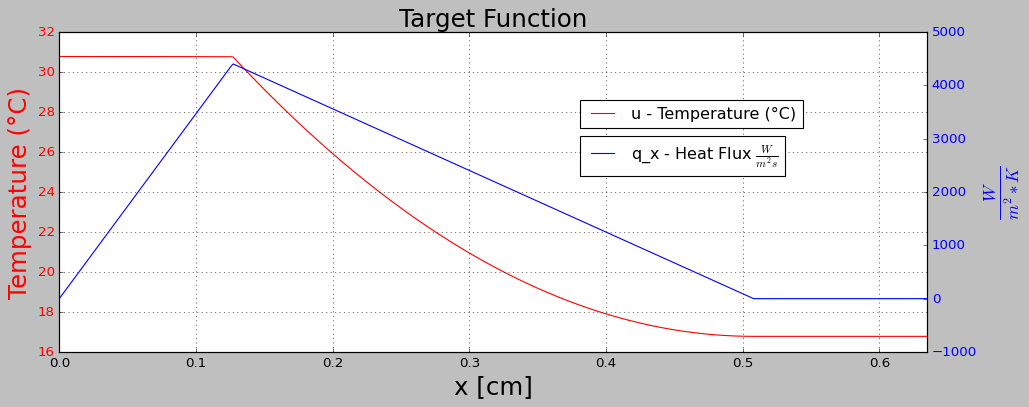

Average temperature [C]: 22.376133771268144


In [18]:
c_star_3 = np.linalg.solve(a_mtrx,b_vec)

n_pts = 500
x_pts = np.linspace(femlb_3.x_a, femlb_3.x_b, n_pts)
N = len(femlb_3.phi_list)

(fig, ax1) = plt.subplots(1, figsize=(14, 5))
ax2 = ax1.twinx()
plt.style.use('classic')
ax1.plot(x_pts/unit.cm, unit.convert_temperature(u_star(x_pts,femlb_3,c_star_3),'K','C'),"r-",label="u - Temperature (°C)")
ax2.plot(x_pts/unit.cm, diff_flux_x_star(x_pts,femlb_3,c_star_3),"b-",label=r"q_x - Heat Flux $\frac{W}{m^2 s}$")
ax1.grid()
plt.title(f"Target Function",fontsize=22)
ax1.set_ylabel(r"Temperature (°C)",fontsize=22, color="red")
ax2.set_ylabel(r"$\frac{W}{{m}^2  * K}$",fontsize=22, color="blue")
ax1.set_xlabel(r"x [cm]",fontsize=22)
ax1.tick_params(axis="y",labelcolor="red")
ax2.tick_params(axis="y",labelcolor="blue")
ax1.legend(loc=(0.6,0.7))
ax2.legend(loc=(0.6,0.55))
ax1.set_xlim(x_a/unit.cm, x_b/unit.cm)
plt.show()

(temp_integral, error) = scipy.integrate.quad(u_star, x_a, x_b,args=(femlb_3,c_star_3), limit=1000, epsrel=10e-7, epsabs=10e-7)
print("Average temperature [C]:", unit.convert_temperature(temp_integral/(x_b-x_a), 'K', 'C'))

In [19]:
left_bound_temp = unit.convert_temperature(u_star(x_a,femlb_3,c_star_3)[0],'K','C')
right_bound_temp = unit.convert_temperature(u_star(x_b,femlb_3,c_star_3)[0],'K','C')

left_bound_flux =diff_flux_x_star(x_a,femlb_3,c_star_3)[0]
right_bound_flux = diff_flux_x_star(x_b,femlb_3,c_star_3)[0]
print("Left bound temperature:",format(left_bound_temp,".2f"),"°C")
print("Right bound temperature:",format(right_bound_temp,".2f"),"°C")
print("*"*60)
print("Left bound flux:",format(left_bound_flux,".2f"),r"W/in2 K")
print("Right bound flux:",format(right_bound_flux,".2f"),r"W/in2 K")
print("\nu_ref:",unit.convert_temperature(x_max_u_ref,'K','C'),"°C")
print("h:", h_coeff, "W/in^2 K")

Left bound temperature: 30.77 °C
Right bound temperature: 16.78 °C
************************************************************
Left bound flux: -0.00 W/in2 K
Right bound flux: -0.00 W/in2 K

u_ref: 17.05000000000001 °C
h: 1e-05 W/in^2 K


In [20]:
import pandas as pd
from IPython.display import HTML

x_table = np.linspace(femlb_3.x_a, femlb_3.x_b,20)

u_values = u_star(x_table, femlb_3, c_star_3) 
q_values = diff_flux_x_star(x_table, femlb_3, c_star_3)

df = pd.DataFrame({"x [cm]":x_table*100,"T [K]":u_values,"q_x [W/m^2]":q_values})
pd.options.display.float_format = '{:,.3f}'.format
HTML(df.to_html(index=False))

x [cm],T [K],q_x [W/m^2]
0.000,303.925,-0.000
0.033,303.924,"1,158.790"
0.067,303.921,"2,317.581"
0.100,303.917,"3,476.371"
0.134,303.427,"4,326.151"
0.167,301.125,"3,939.888"
0.201,299.038,"3,553.624"
0.234,297.166,"3,167.361"
0.267,295.509,"2,781.097"
0.301,294.068,"2,394.834"


## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5330: Computational Transport Phenomena*](https://github.com/dpploy/engy-5330), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).